# Exploratory Data Analysis (EDA) for Time Series Forecasting

This notebook documents the EDA for TSLA, BND, and SPY datasets, covering cleaning verification, trends, volatility, outliers, returns, seasonality, and risk metrics. Data is cleaned and normalized from `data/processed/`.

In [12]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import os

## Data Loading and Verification
Load cleaned data and verify structure.

In [13]:
input_path = "C:/Users/Skyline/Time Series Forecasting/data/processed"
tickers = ["TSLA", "BND", "SPY"]
dataframes = {}
for ticker in tickers:
    file_path = os.path.join(input_path, f"{ticker}_cleaned.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        dataframes[ticker] = df
        print(f"{ticker} loaded with columns: {df.columns.tolist()}")
    else:
        print(f"No data for {ticker}")

TSLA loaded with columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
BND loaded with columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
SPY loaded with columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


## Visualize Closing Price Over Time
Identify trends and patterns in normalized closing prices.

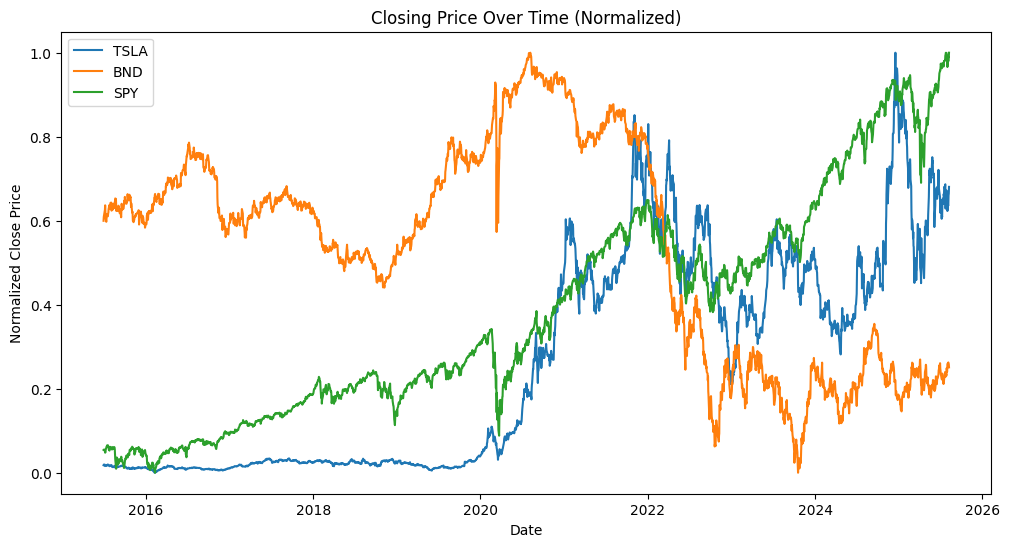

In [14]:
plt.figure(figsize=(12, 6))
for ticker, df in dataframes.items():
    plt.plot(df.index, df['Close'], label=ticker)
plt.title("Closing Price Over Time (Normalized)")
plt.xlabel("Date")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.show()

## Daily Percentage Change and Volatility
Analyze volatility with daily returns and rolling statistics.

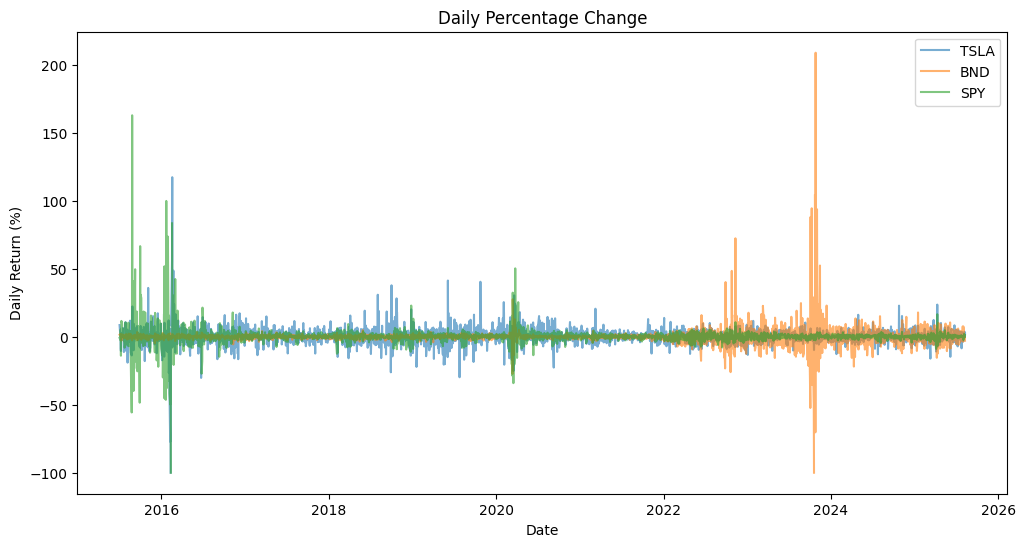

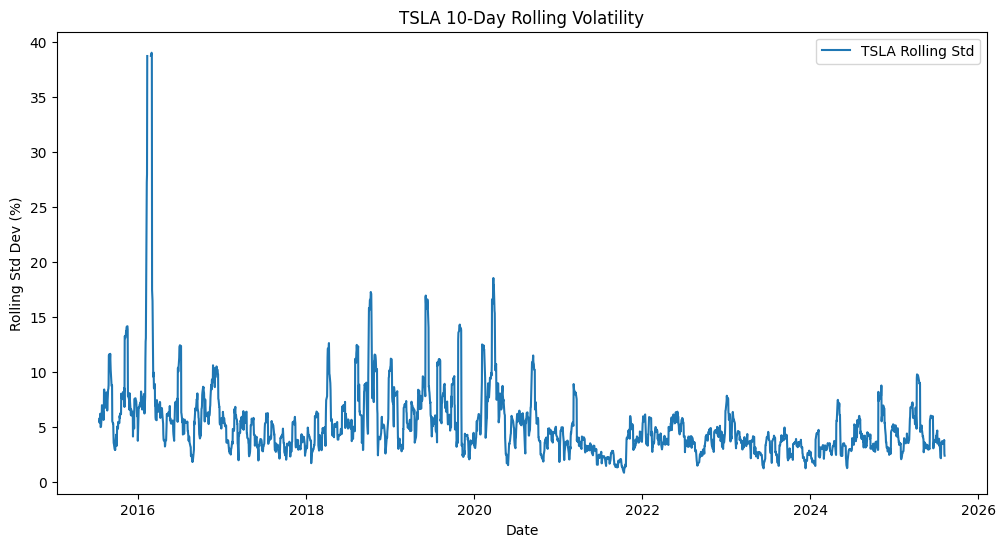


TSLA Rolling Mean Sample: 0.3180100254270715
TSLA Rolling Std Sample: 5.126421835767934


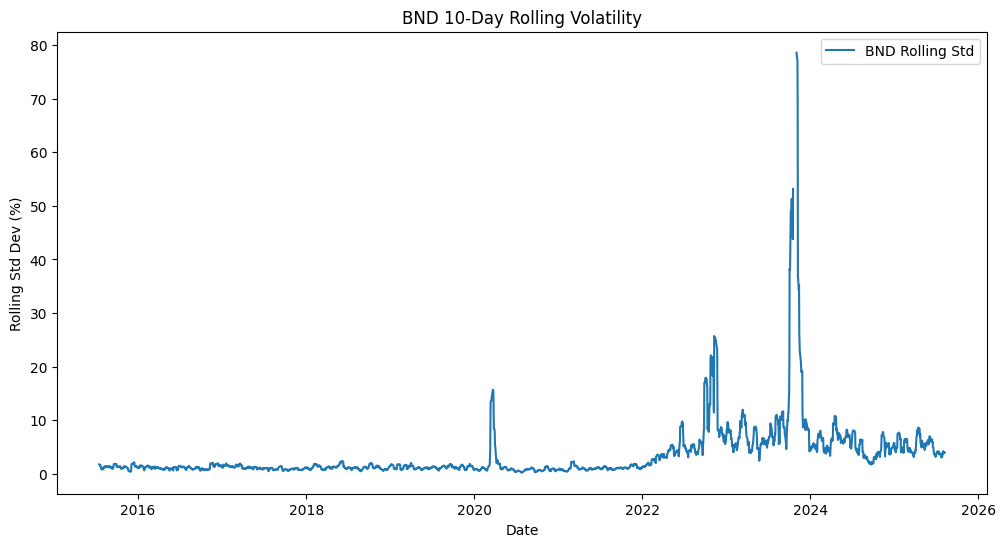


BND Rolling Mean Sample: 0.15799301018106937
BND Rolling Std Sample: 3.41241307688698


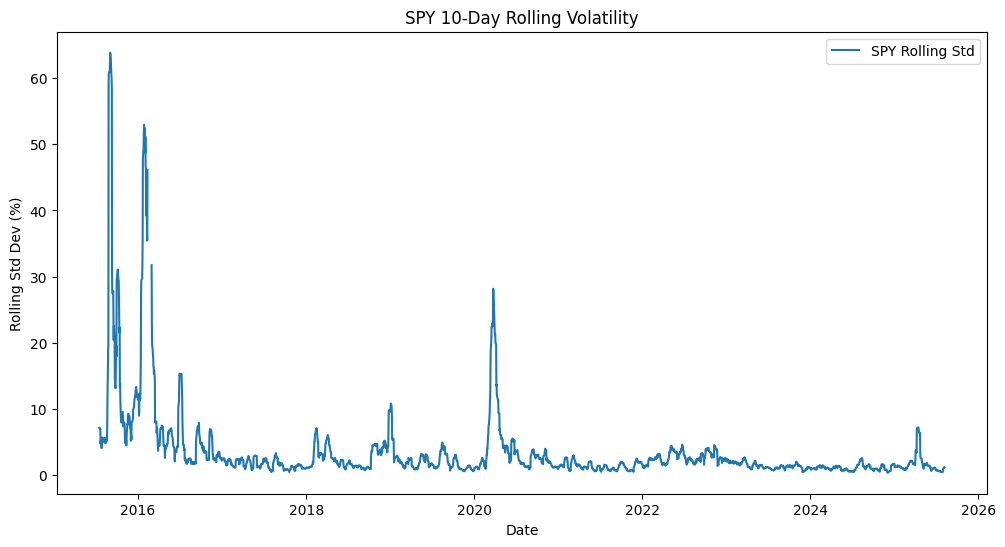


SPY Rolling Mean Sample: 0.3057207516066812
SPY Rolling Std Sample: 3.4754443604281686


In [23]:
plt.figure(figsize=(12, 6))
for ticker, df in dataframes.items():
    # Calculate Daily Return and clean it
    df['Daily Return'] = df['Close'].pct_change() * 100
    df['Daily Return'] = df['Daily Return'].replace([float('inf'), float('-inf')], float('nan')).dropna()
    plt.plot(df.index, df['Daily Return'], label=ticker, alpha=0.6)
plt.title("Daily Percentage Change")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.legend()
plt.show()

# Rolling Volatility
window = 10  # Reduced for sensitivity
for ticker, df in dataframes.items():
    df['Daily Return'] = df['Daily Return'].dropna()  # Ensure no NaN/inf
    df['Rolling Mean'] = df['Daily Return'].rolling(window=window).mean()
    df['Rolling Std'] = df['Daily Return'].rolling(window=window).std()
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Rolling Std'], label=f"{ticker} Rolling Std")
    plt.title(f"{ticker} 10-Day Rolling Volatility")
    plt.xlabel("Date")
    plt.ylabel("Rolling Std Dev (%)")
    plt.legend()
    plt.show()
    print(f"\n{ticker} Rolling Mean Sample: {df['Rolling Mean'].mean()}")
    print(f"{ticker} Rolling Std Sample: {df['Rolling Std'].mean()}")

In [22]:
for ticker, df in dataframes.items():
    print(f"\n{ticker} Daily Return NaN count: {df['Daily Return'].isna().sum()}")
    print(f"{ticker} Daily Return inf count: {df['Daily Return'].isin([float('inf'), float('-inf')]).sum()}")


TSLA Daily Return NaN count: 2
TSLA Daily Return inf count: 0

BND Daily Return NaN count: 0
BND Daily Return inf count: 1

SPY Daily Return NaN count: 0
SPY Daily Return inf count: 1


## Outlier Detection and High/Low Returns
Identify significant anomalies and days with extreme returns.

In [25]:
threshold = 3
for ticker, df in dataframes.items():
    mean_return = df['Daily Return'].mean()
    std_return = df['Daily Return'].std()
    outliers = df[abs(df['Daily Return'] - mean_return) > threshold * std_return]
    print(f"\nOutliers for {ticker} (>{threshold} std devs):")
    print(outliers[['Daily Return']])

high_threshold, low_threshold = 3, -3
for ticker, df in dataframes.items():
    high_returns = df[df['Daily Return'] > high_threshold]
    low_returns = df[df['Daily Return'] < low_threshold]
    print(f"\n{ticker} Days with High Returns (> {high_threshold}%):")
    print(high_returns[['Daily Return']])
    print(f"{ticker} Days with Low Returns (< {low_threshold}%):")
    print(low_returns[['Daily Return']])


Outliers for TSLA (>3 std devs):
            Daily Return
Date                    
2015-08-27     22.360480
2015-11-04     35.992578
2016-02-02    -26.581552
2016-02-03    -23.779081
2016-02-05    -40.208477
2016-02-08    -77.179074
2016-02-10   -100.000000
2016-02-16     56.038236
2016-02-17    117.477975
2016-02-22     48.712321
2016-02-25     23.860713
2016-06-22    -30.221221
2018-08-02     30.985569
2018-09-28    -26.090941
2018-10-01     37.927339
2018-10-23     28.299779
2019-01-18    -22.122365
2019-05-17    -20.434669
2019-06-04     41.444809
2019-07-25    -29.750013
2019-10-24     40.536891
2020-02-03     25.533633
2020-02-05    -20.495299
2020-03-16    -25.201639
2020-03-18    -24.074270
2020-03-19     30.530909
2020-03-24     24.330744
2020-09-08    -22.616317
2024-10-24     22.947792
2025-04-09     23.713745

Outliers for BND (>3 std devs):
            Daily Return
Date                    
2020-03-12    -27.321089
2020-03-13     27.583394
2022-09-28     40.293327
2022-10-

## Seasonality and Trends
Perform Augmented Dickey-Fuller (ADF) test to assess stationarity.

In [28]:
for ticker, df in dataframes.items():
    print(f"\nADF Test for {ticker} Closing Prices:")
    result = adfuller(df['Close'].dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")
    print("Implication: Non-stationary series requires differencing ('I' in ARIMA).")
    print(f"\nADF Test for {ticker} Daily Returns:")
    df['Daily Return'] = df['Close'].pct_change() * 100
    df['Daily Return'] = df['Daily Return'].replace([float('inf'), float('-inf')], float('nan'))
    print(f"{ticker} Daily Return NaN count after replacement: {df['Daily Return'].isna().sum()}")
    print(f"{ticker} Daily Return inf count after replacement: {df['Daily Return'].isin([float('inf'), float('-inf')]).sum()}")
    clean_returns = df['Daily Return'].dropna().reset_index(drop=True)
    print(f"{ticker} Clean Returns length after dropna: {len(clean_returns)}")
    print(f"{ticker} Clean Returns NaN count: {clean_returns.isna().sum()}")
    print(f"{ticker} Clean Returns inf count: {clean_returns.isin([float('inf'), float('-inf')]).sum()}")
    result = adfuller(clean_returns)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")
    print("Implication: Stationary returns can be modeled directly.")


ADF Test for TSLA Closing Prices:
ADF Statistic: -1.350794227772497
p-value: 0.6056256970865406
Non-Stationary
Implication: Non-stationary series requires differencing ('I' in ARIMA).

ADF Test for TSLA Daily Returns:
TSLA Daily Return NaN count after replacement: 2
TSLA Daily Return inf count after replacement: 0
TSLA Clean Returns length after dropna: 2540
TSLA Clean Returns NaN count: 0
TSLA Clean Returns inf count: 0
ADF Statistic: -14.913088789108922
p-value: 1.4486150248706359e-27
Stationary
Implication: Stationary returns can be modeled directly.

ADF Test for BND Closing Prices:
ADF Statistic: -0.8207968245812416
p-value: 0.8129367018737841
Non-Stationary
Implication: Non-stationary series requires differencing ('I' in ARIMA).

ADF Test for BND Daily Returns:
BND Daily Return NaN count after replacement: 2
BND Daily Return inf count after replacement: 0
BND Clean Returns length after dropna: 2540
BND Clean Returns NaN count: 0
BND Clean Returns inf count: 0
ADF Statistic: -8.8